In [55]:
import os
import shutil
import subprocess
import time
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from tqdm import tqdm

base_path = '/home/rdkit-xtb-geomopt'

## Read molecules from CSV file

## Embed RdKit Mol objects into 3D space and save XYZ files

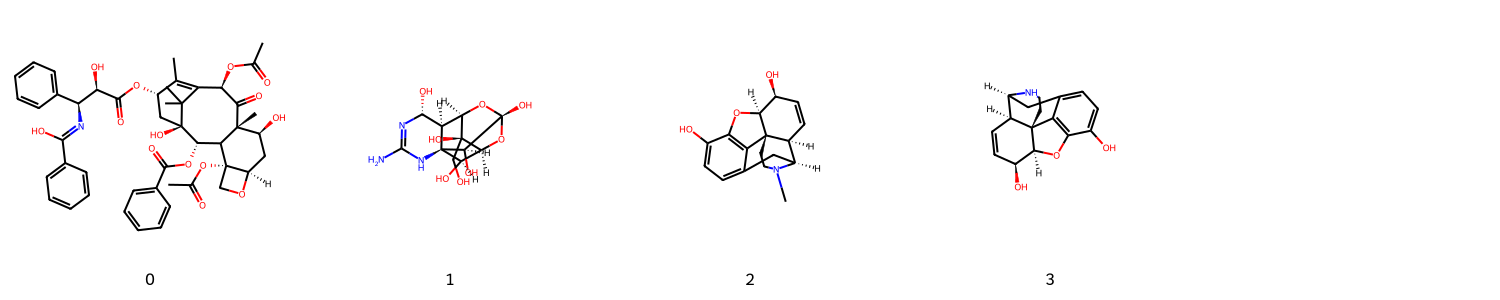

In [57]:
smiles_list = ["CC1=C2[C@H](C(=O)[C@]3(C)[C@H](C[C@@H]4[C@@](CO4)(C3[C@@H]([C@](C[C@@H]1OC(=O)[C@@H]([C@H](C5=CC=CC=C5)N=C(C6=CC=CC=C6)O)O)(C2(C)C)O)OC(=O)C7=CC=CC=C7)OC(=O)C)O)OC(=O)C", "C([C@@]1([C@H]2[C@@H]3[C@H](N=C(N)N[C@@]34[C@@H]([C@@H]1O[C@@]([C@H]4O)(O)O2)O)O)O)O", "CN1CC[C@]23[C@H]4C=C[C@@H]([C@@H]2OC5=C3C(=CC=C5O)C[C@@H]41)O", "	C1=C2C[C@H]3[C@@H]4C=C[C@@H]([C@H]5[C@@]4(CCN3)C2=C(C(=C1)O)O5)O"]

mol_list = []
for smiles in smiles_list:
    mol = Chem.MolFromSmiles(smiles, sanitize=True)
    mol.SetProp("_Name", f"{smiles}")
    mol_list.append(mol)

legends = [str(x) for x in range(len(mol_list))]
Draw.MolsToGridImage(mol_list, molsPerRow= 5, subImgSize=(300,300), legends=legends, returnPNG=False)

In [78]:
path_to_xyz = base_path + f'/xyz'
path_to_xtbopt = base_path + f'/xtb'

def clean_directory(directory):
    # Check if the directory exists
    if not os.path.exists(directory):
        print(f"Directory '{directory}' does not exist. Creating...")
        try:
            os.makedirs(directory)  # Create the directory and any missing parent directories
            print(f"Directory '{directory}' created successfully.")
        except Exception as e:
            print(f"Error creating directory '{directory}': {e}")
        return

    # Check if it's a directory
    if not os.path.isdir(directory):
        print(f"'{directory}' is not a directory.")
        return

    # Get list of files and subdirectories in the directory
    files_and_subdirectories = os.listdir(directory)

    # If the directory is empty, do nothing
    if not files_and_subdirectories:
        print(f"Directory '{directory}' is empty. Nothing to delete.")
        return

    # If the directory is not empty, delete files and subdirectories recursively
    for item in files_and_subdirectories:
        item_path = os.path.join(directory, item)
        try:
            if os.path.isfile(item_path):
                os.remove(item_path)
                print(f"Deleted file: {item}")
            elif os.path.isdir(item_path):
                clean_directory(item_path)  # Recursively delete subdirectories
                os.rmdir(item_path)  # Remove the empty subdirectory
                print(f"Deleted directory: {item_path}")
        except Exception as e:
            print(f"Error deleting {item_path}: {e}")

Deleted file: xtb_input_1.xyz
Deleted file: xtb_input_0.xyz
Deleted file: xtb_input_3.xyz
Deleted file: xtb_input_2.xyz


In [90]:
clean_directory(path_to_xyz)

for i, mol in tqdm(enumerate(mol_list)):
    if mol is None:
        continue
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, randomSeed=42)
    AllChem.MMFFOptimizeMolecule(mol)
    time.sleep(0.05)
    try:
        xyz_content = f"{mol.GetNumAtoms()}\n"

        if mol_list[0].HasProp("_Name"):
            xyz_content += f'{mol.GetProp("_Name")}\n'
        else:
            xyz_content += "\n"
        for atom in mol.GetAtoms():
            pos = mol.GetConformer().GetAtomPosition(atom.GetIdx())
            xyz_content += f"{atom.GetSymbol()} {pos.x} {pos.y} {pos.z}\n"


        for atom in mol.GetAtoms():
            pos = mol.GetConformer().GetAtomPosition(atom.GetIdx())
            xyz_content += f"{atom.GetSymbol()} {pos.x} {pos.y} {pos.z}\n"
    except:
        continue

    with open(path_to_xyz + f"/xtb_input_{i}.xyz", "w") as xyz_file:
        xyz_file.write(xyz_content)


Deleted file: xtb_input_1.xyz
Deleted file: xtb_input_0.xyz
Deleted file: xtb_input_3.xyz
Deleted file: xtb_input_2.xyz


4it [00:02,  1.70it/s]


## Geometry optimization using xTB-python

In [101]:
def xtb_optimize_geometries(path_to_xyz, 
                            path_to_xtbopt, 
                            gfn_xtb=2,
                            opt_lvl='normal',
                            num_opt_cycles=None,
                            solvent=None,
                            unpaired_e=None,
                            ):
    if not os.path.exists(path_to_xyz):
        print(f"Directory '{path_to_xyz}' does not exist.")
        return

    xyz_files_list = os.listdir(path_to_xyz)
    xyz_files_list = sorted(xyz_files_list)
    if not xyz_files_list:
        print(f"Directory '{path_to_xyz}' is empty.")
        return
    #check if all files in path_to_xyz directory are have xyz extensions
    for xyz_file in xyz_files_list:
        if not xyz_file.endswith('.xyz'):
            print(f"Directory '{path_to_xyz}' contains non-XYZ files.\nConsider removing these files.")
            return

    if not os.path.exists(path_to_xtbopt):
        print(f"Directory '{path_to_xtbopt}' does not exist.")
        return
    
    xtbopt_files_list = os.listdir(path_to_xtbopt)
    if xtbopt_files_list:
        print(f"Directory '{path_to_xtbopt}' is not empty. \nPlease empty the directory before starting the xtb geometry optimization.")
        return
    
    xtb_flags = []

    if gfn_xtb==2:
        pass
    elif gfn_xtb==1 or gfn_xtb==0:
        xtb_flags+=["--gfn", gfn_xtb]
    else:
        print("Invalid xTB parametrization. Choose from 2 (default), 1 or 0. Integer input.")
        return



    # check if chosen opt lvl is valid
    valid_opt_lvls=["crude", "sloppy", "loose", "lax", "normal", "tight", "vtight", "extreme"]
    if opt_lvl not in valid_opt_lvls:
        print(f'Chosen xTB geometry optimization level is not valid.\n'+
              'Please choose one from the list: ', valid_opt_lvls)
        return
    xtb_flags+=["--opt", opt_lvl]

    if num_opt_cycles is not None:
        if not isinstance(num_opt_cycles, int):
            print(f"Num_opt_cycles shall be in int format, but {type(num_opt_cycles)} was given instead.")
            return
        xtb_flags+=["--cycles", str(num_opt_cycles)]

    if solvent is not None:
        ##check if the solvent is correct
        available_solvents = ["acetone", 'acetonitrile', 'benzene', 'ch2cl2', 'chcl3', 'cs2', 
                                    'dioxane', 'dmf', 'dmso', 'ether', 'ethylacetate', 'furane', 
                                    'hexane', 'methanol', 'nitromethane', 'toluene', 'thf', 'water']
        if not isinstance(solvent, str):
            print(f"Solvent input shall be in string format, but {type(solvent)} was given instead.")
            return
        elif solvent.lower() not in available_solvents:
            print(f"Invalid solvent choice. \nPlease choose one from the list: ", available_solvents)
            return
        xtb_flags+=["--alpb", solvent]

    if unpaired_e is not None:
        ##check if the format is correct
        xtb_flags+=["--uhf", unpaired_e]
    
    print(xyz_files_list)

    for i, xyz_file in enumerate(xyz_files_list):
        
        start = time.time()
        os.makedirs(path_to_xtbopt+f"/{i}")
        xyz_for_xtb_opt = path_to_xtbopt+f"/{i}/{xyz_file}"
        shutil.copy(path_to_xyz+f"/{xyz_file}", xyz_for_xtb_opt)
        os.chdir(path_to_xtbopt+f"/{i}")
        subprocess.run(["xtb", xyz_for_xtb_opt] + xtb_flags)
        ##
        ##add checking if xtb optimization crashed for the file or was successfull


        end = time.time()  
        print(end-start)

        ##
        ##get geometry optimization statistics including (1) elapsed time for each input, (2) num of iterations for each, (3) num successful, (4) num failed.
    return

xtb_optimize_geometries(path_to_xyz, path_to_xtbopt) ## now lets put hyper

Directory '/home/slava/Documents/Galymzhan/rdkit-xtb-geomopt/xtb' is not empty. 
Please empty the directory before starting the xtb geometry optimization.
